In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os.path
from pathlib import Path
import time
import pandas as pd
import pickle as pkl
import librosa as lb
from sklearn import metrics

In [2]:
hop_sec = 512 * 1 / 22050
n_cores = 8
downsample = 1

In [3]:
ANNOTATIONS_ROOT_CLEAN = Path('/home/cchang/ttmp/raw_data/Chopin_Mazurkas/annotations_beat')
FEATURES_ROOT_CLEAN = Path('/home/cchang/ttmp/features/clean')

In [4]:
times = np.array([5, 10, 15, 20, 25, 30])
# times = [15]
#folder_names = ['dtw1', 'dtw2', 'dtw3', 'dtw4', 'subseqdtw', 'nwtw/gamma_0.346']
# folder_names = ['nwtw/gamma_0.8']

cfg_options = ['toy', 'small', 'medium', 'train_benchmark']
cfg = cfg_options[1] # Change this to appropriate benchmark

if cfg == 'toy':
    query_list = 'cfg_files/query.train_toy.list'
elif cfg == 'small':
    query_list = 'cfg_files/query.train_small.list'
elif cfg == 'medium':
    query_list = 'cfg_files/query.train_medium.list'
else:
    query_list = 'cfg_files/query.train.list'

In [5]:
# *** Edit these 2 lines as we add more systems ****
# savefile_names = ['dtw233.pkl', 'dtw111.pkl']
# folder_names = ['dtw233', 'dtw111']

# betas = [1, 2, 5, 10, 15, 20]
# savefile_names = ['hstw_gamma_20_beta_' + str(beta) + '.pkl' for beta in betas]
# folder_names = ['hstw/gamma_20_beta_' + str(beta) for beta in betas]
# savefile_names = ['hstw_gamma_20_beta_10.pkl']
# folder_names = ['hstw/gamma_20_beta_10']
savefile_names = ['dtw233.pkl', 'dtw111.pkl', 'nwtw_gamma_0.8']
folder_names = ['dtw233', 'dtw111', 'nwtw/gamma_0.8']

## Alignment

### Functions

In [5]:
def eval_dir(hypdir, querylist, hop_sec, scoring_collar = 0.1, annot_root_query = ANNOTATIONS_ROOT_CLEAN, \
             annot_root_ref = ANNOTATIONS_ROOT_CLEAN, features_query = FEATURES_ROOT_CLEAN, \
             features_ref = FEATURES_ROOT_CLEAN, savefile = None, verbose=False, partial_match=False, **kwargs):
    
    if savefile:
        outdir = os.path.dirname(savefile)
        outdir = Path(outdir)
        outdir.mkdir(parents=True, exist_ok=True)
    
    # Initialize dictionaries
    allErrs = {}
    allCosts = {}
    allAtrGT = {}
    
    cnt = 0
    if verbose:
        print(f'Processing {hypdir} ', end='')
        
    # assumes that if partial_match, the query dir has replacement_ts.csv file on the same level as annot_root_query
    if partial_match:
        
        assert('replacement_ts_file' in kwargs)
        
        df = pd.read_csv(kwargs['replacement_ts_file'])
        #df = pd.read_csv((annot_root_query.parent / 'replacement_ts.csv').as_posix())
        allTimestamps = df.set_index('name').to_dict(orient='index')
        
    with open(querylist, 'r') as f:
        for line in f:
            parts = line.strip().split()
            assert len(parts) == 2
            basename = os.path.basename(parts[0]) + '__' + os.path.basename(parts[1])
            hypfile = hypdir + '/' + basename + '.pkl'
            
            if not os.path.exists(hypfile):
                print("X", end='')
                continue
                
            if partial_match:
                downsample = 1

                times = allTimestamps[os.path.basename(parts[0]) + '.wav']
                firstRepEndIdx = times['beginning replacement end (idx)']
                midRepStartIdx = times['middle replacement start (idx)']
                midRepEndIdx = times['middle replacement end (idx)']
                lastRepStartIdx = times['ending replacement start (idx)']
                allErrs[basename] = eval_align_partial_matching(hypfile, hop_sec, firstRepEndIdx, midRepStartIdx, \
                                                                midRepEndIdx, lastRepStartIdx, scoring_collar, \
                                                                downsample, annot_root_query,  annot_root_ref, \
                                                                features_query, features_ref)
                
            else:
                allErrs[basename] = eval_file(hypfile, hop_sec, annot_root_ref, annot_root_query)
            cnt += 1
            if cnt % 500 == 0:
                print(".", end='')
                
    if verbose:
        print(' done')
    if savefile:
        
        if partial_match:
            pkl.dump([allErrs, allCosts, allAtrGT], open(savefile, 'wb'))
        else:
            pkl.dump(allErrs, open(savefile, 'wb'))
        
    return allErrs


In [6]:
def eval_align_partial_matching(hypfile, hop_sec, firstRepEndIdx, midRepStartIdx, midRepEndIdx, lastRepStartIdx, \
                                scoring_collar = 0.1, downsample = 1, annot_query = ANNOTATIONS_ROOT_CLEAN, \
                                annot_ref = ANNOTATIONS_ROOT_CLEAN, features_query = FEATURES_ROOT_CLEAN,\
                                features_ref = FEATURES_ROOT_CLEAN):
    '''
    
    First file (query) = Tampered query
    Second file (ref) = clean reference
    
    '''
    
    parts = os.path.basename(hypfile).split('__')
    assert len(parts) == 2
    piece = extractPieceName(parts[0])
    
    annotfile_query = (annot_query / piece / parts[0]).with_suffix('.beat')
    annotfile_ref = (annot_ref / piece / parts[1]).with_suffix('.beat')
    
    featfile_query = (features_query / piece / parts[0]).with_suffix('.npy')
    featfile_ref = (features_ref / piece / parts[1]).with_suffix('.npy')
    
    gt_query, gt_ref = getTimestamps(annotfile_query), getTimestamps(annotfile_ref)
        
    hypalign = loadAlignment(hypfile) # warping path in frames
    
    if hypalign is None:
#         gt_attribution = []
        err = None
    else:
        
        # Alignment Error
        # for HPTW, hypalign is in the form [visible path, hidden path]
        err = getAlignmentError(gt_query, gt_ref, hop_sec, firstRepEndIdx, midRepStartIdx, midRepEndIdx, lastRepStartIdx, hypalign, scoring_collar)
              
#         # Attribution Cost
#         hop_frames = hop_sec * 22050
                
#         frame_cost, gt_attribution = getAttributionCost(featfile_query, featfile_ref, hop_frames, firstRepEndIdx, midRepStartIdx, midRepEndIdx, lastRepStartIdx, hypalign, algorithm = algorithm, hidden_path = None, downsample = 1)
        
#         frame_cost = []
#         gt_attribution = []
        
    return err

In [7]:
def getAlignmentError(gt_query, gt_ref, hop_sec, firstRepEndIdx, midRepStartIdx, midRepEndIdx, lastRepStartIdx, \
                      hypalign, scoring_collar = 0.1, sr = 22050):
    '''
    Computes alignment error on untampered regions
    
    Inputs:
    gt_query: ground truth ts of query beats in seconds
    gt_ref: ground truth ts of reference beats in seconds
    hop_sec: hop size in seconds
    firstRepEndIdx: ending idx of first replacement section
    midRepStartIdx: starting idx of middle replacement section
    midRepEndIdx: ending idx of middle replacement section
    lastRepStartIdx: starting idx of last replacement section
    hypalign: predicted warping path
    
    Outputs:
    err: error in seconds between prediction and ground truth
    
    '''
    # hypalign[:,0] corresponds to query audio
    # hypalign[:,1] corresponds to ref audio
    
    scoring_collar_frames = scoring_collar * sr
    
    # Get indices to exclude from gt_query 
    startExclude = np.argwhere(gt_query * sr < firstRepEndIdx + scoring_collar_frames)
    midExclude = np.argwhere(np.logical_and(gt_query * sr > midRepStartIdx - scoring_collar_frames, \
                                            gt_query * sr < midRepEndIdx + scoring_collar_frames))
    endExclude = np.argwhere(gt_query * sr > lastRepStartIdx - scoring_collar_frames)

    excludedIdx = np.concatenate((startExclude, midExclude, endExclude)).flatten()
    keepIdx = np.setdiff1d(np.arange(len(gt_query)), excludedIdx)
    
    gt_query_valid = gt_query[keepIdx]

    # Calculate predictions via interpolation only on ground truth valid frames in query
    pred_ref = np.interp(gt_query_valid, np.array(hypalign['wp'][:,0]*hop_sec), np.array(hypalign['wp'][:,1]*hop_sec))

    
    # OLD format for HPTW
    # HPTW has warping path in the form [visible plane, hidden plane]
#     if algorithm == 'HPTW':
#         pred_ref = np.interp(gt_query_valid, hypalign['wp'][0][:,0]*hop_sec, hypalign['wp'][0][:,1]*hop_sec)
#     else:
#         pred_ref = np.interp(gt_query_valid, hypalign['wp'][:,0]*hop_sec, hypalign['wp'][:,1]*hop_sec)

    # Calculate error
    err = pred_ref - gt_ref[keepIdx]
    
    return err

In [8]:
def getTimestamps(annotfile):
    df = pd.read_csv(annotfile, header=None, sep='\s+', skiprows=3)
    return np.array(df[0])


def extractPieceName(fullpath):
    basename = os.path.basename(fullpath) # e.g. Chopin_Op068No3_Sztompka-1959_pid9170b-21
    parts = basename.split('_')
    piece = '_'.join(parts[0:2]) # e.g. Chopin_Op068No3
    return piece

def loadAlignment(hypfile):
    with open(hypfile, 'rb') as f:
        d = pkl.load(f)
    return d


### Run Alignments

In [9]:
savefile_names = ['hstw_gamma_20_beta_10.pkl']
folder_names = ['hstw/gamma_20_beta_10']
# **************************************************
for t in times:

    EXPERIMENTS_ROOT = '/home/cchang/ttmp/partial_match/%s/experiments/align_clean_to_%ss' % (cfg, t)
    EVALUATIONS_ROOT = '/home/cchang/ttmp/partial_match/%s/evaluations/alignment/align_clean_to_%ss' % (cfg, t)
#     query = Path('/home/cchang/ttmp/raw_data/partial_match/Chopin_Mazurkas_partial_match_%ss/annotations_beat' % t)
    ts = '/home/cchang/ttmp/raw_data/partial_match/Chopin_Mazurkas_partial_match_%ss/replacement_ts.csv' % t
    
    for i in range(len(savefile_names)): #range(6) is normal, skipping 0 since we've already calculated that
        savefile = EVALUATIONS_ROOT + "/" + savefile_names[i]
        hypdir = EXPERIMENTS_ROOT + "/" + folder_names[i]
        print(hypdir)

        start = time.time()
#         if i == 5: # =5 if regular
#             all_errors_test, allCosts, allAtrGT = eval_dir(hypdir, query_list, hop_sec, savefile = savefile, partial_match=True, replacement_ts_file=ts, algorithm='NWTW')
#         else:
        all_errors_test = eval_dir(hypdir, query_list, hop_sec, savefile = savefile, partial_match=True, replacement_ts_file=ts)
        print('Took ', time.time() - start)

/home/cchang/ttmp/partial_match/small/experiments/align_clean_to_5s/hstw/gamma_20_beta_10
Took  0.35593104362487793
/home/cchang/ttmp/partial_match/small/experiments/align_clean_to_10s/hstw/gamma_20_beta_10
Took  0.3134429454803467
/home/cchang/ttmp/partial_match/small/experiments/align_clean_to_15s/hstw/gamma_20_beta_10
Took  0.3554813861846924
/home/cchang/ttmp/partial_match/small/experiments/align_clean_to_20s/hstw/gamma_20_beta_10
Took  0.3545396327972412
/home/cchang/ttmp/partial_match/small/experiments/align_clean_to_25s/hstw/gamma_20_beta_10
Took  0.35909509658813477
/home/cchang/ttmp/partial_match/small/experiments/align_clean_to_30s/hstw/gamma_20_beta_10
Took  0.3541910648345947


### Alignment Figures

In [10]:
def calc_error_rates(errFile, maxTol, justErrorFile = False):
    
    # read from file
    with open(errFile, 'rb') as f:
        if justErrorFile:
            allErrs = pkl.load(f)
        else:
            allErrs, _, _ = pkl.load(f)
    
    # collect all errors
    errsFlat = []
    for query in allErrs:
        if allErrs[query] is not None:
            errs = np.array(allErrs[query])
            errsFlat.append(errs)
    errsFlat = np.concatenate(errsFlat)
    
    # calculate error rates
    errRates = np.zeros(maxTol+1)
    for i in range(maxTol+1):
        errRates[i] = np.mean(np.abs(errsFlat) > i/1000)
    
    return errRates, errsFlat

In [11]:
allErrors = []

for t in times:

    EVALUATIONS_ROOT = '/home/cchang/ttmp/partial_match/%s/evaluations/alignment/align_clean_to_%ss' % (cfg, t)

    error_rate_tests = []

    for i in range(len(savefile_names)): # 6 in normal timesb
        savefile = EVALUATIONS_ROOT + "/" + savefile_names[i]
        print(savefile)
        error_rate_tests.append(calc_error_rates(savefile, 1000)[0])
#         err = calc_error_rates(savefile, 1000)[0]

    allErrors.append(error_rate_tests)

/home/cchang/ttmp/partial_match/small/evaluations/alignment/align_clean_to_5s/hstw_gamma_20_beta_10.pkl
/home/cchang/ttmp/partial_match/small/evaluations/alignment/align_clean_to_10s/hstw_gamma_20_beta_10.pkl
/home/cchang/ttmp/partial_match/small/evaluations/alignment/align_clean_to_15s/hstw_gamma_20_beta_10.pkl
/home/cchang/ttmp/partial_match/small/evaluations/alignment/align_clean_to_20s/hstw_gamma_20_beta_10.pkl
/home/cchang/ttmp/partial_match/small/evaluations/alignment/align_clean_to_25s/hstw_gamma_20_beta_10.pkl
/home/cchang/ttmp/partial_match/small/evaluations/alignment/align_clean_to_30s/hstw_gamma_20_beta_10.pkl


In [47]:
# allErrors[timeIdx][systemIdx]
print(allErrors[0][0])
print(allErrors[0][1])
print(allErrors[0][2])
print(allErrors[0][3])

[0.99993956 0.97213491 0.94354449 ... 0.0672147  0.06715426 0.06709381]
[0.99993956 0.97177224 0.94294004 ... 0.06636847 0.06630803 0.06630803]
[0.99987911 0.97116779 0.94082447 ... 0.06413201 0.06407157 0.06407157]
[0.99987911 0.97153046 0.94148936 ... 0.06479691 0.06473646 0.06473646]


In [36]:
folder_names

['hstw/gamma_20_beta_10']

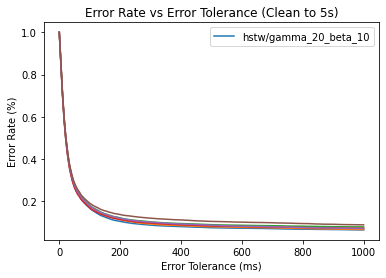

In [12]:
for curve in allErrors:
    plt.plot(curve[0])

plt.xlabel('Error Tolerance (ms)')
plt.ylabel('Error Rate (%)')
plt.legend(folder_names)
plt.title('Error Rate vs Error Tolerance (Clean to 5s)')
plt.show()

In [14]:
def plotAlignment(timesToPlot, systemsToPlot, legend, cfg, title="Alignment Error Rates"):
    fig, axs = plt.subplots(1, len(timesToPlot), figsize = (11, 7))
    x = np.arange(4)
    numBars = len(systemsToPlot)
    width = 0.75 / numBars
    
    for i, plotTime in enumerate(timesToPlot):
        
        axs[i].grid(zorder=0)
        for j, plotSys in enumerate(systemsToPlot):
            errorsFile = '/home/cchang/ttmp/partial_match/%s/evaluations/alignment/align_clean_to_%ss/%s.pkl' \
                % (cfg, str(plotTime), plotSys)
            errorCurve = calc_error_rates(errorsFile, 1000)[0]
            axs[i].bar(x - width * (numBars / 2) + (j + 1/2) * width, errorCurve[[20, 50, 100, 200]] * 100, width, zorder = 3)
#         axs[i].set_xlabel("Error Tolerance (ms)")
        axs[i].set_xticks(x)
        axs[i].set_xticklabels([20, 50, 100, 200])
        axs[i].set_ylim(0,80)
        axs[i].set_title("L = " + str(plotTime))

    plt.legend(legend, loc = (1.1, 0.5))
    fig.suptitle(title, fontsize = 'x-large')
    axs[0].set_ylabel("Error Rate (%)", fontsize = "large")
    axs[len(timesToPlot)//2].set_xlabel("Error Tolerance (ms)", fontsize = "large")
    fig.tight_layout()

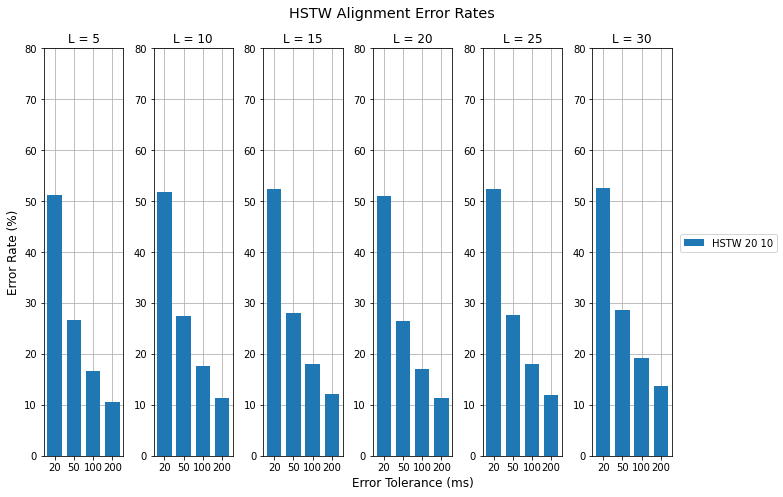

In [15]:
timesToPlot = [5, 10, 15, 20, 25, 30]

systemsToPlot = ['hstw_gamma_20_beta_10']
legend = ["HSTW 20 10"]
cfg = cfg

plotAlignment(timesToPlot, systemsToPlot, legend, cfg, title="HSTW Alignment Error Rates")

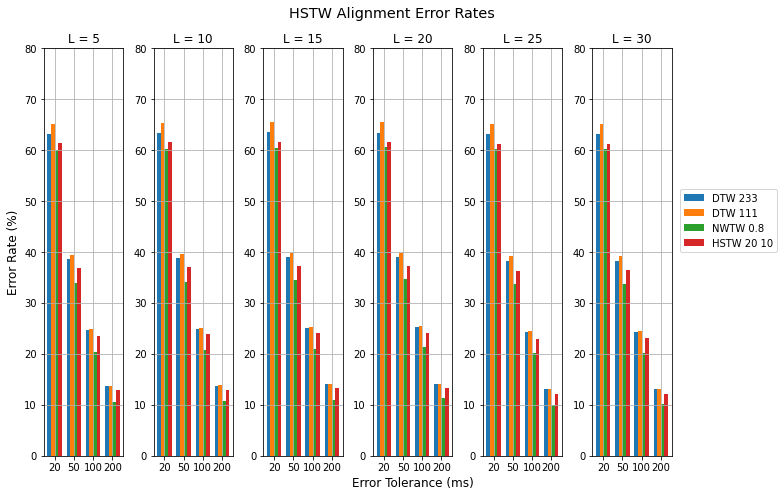

In [64]:
timesToPlot = [5, 10, 15, 20, 25, 30]

systemsToPlot = ['dtw233', 'dtw111', 'nwtw_gamma_0.8', 'hstw_gamma_20_beta_10']
legend = ["DTW 233", "DTW 111", "NWTW 0.8", "HSTW 20 10"]
cfg = cfg

plotAlignment(timesToPlot, systemsToPlot, legend, cfg, title="HSTW Alignment Error Rates")

hstw_gamma_20_beta_1
/home/cchang/ttmp/partial_match/small/evaluations/alignment/align_clean_to_5s/hstw_gamma_20_beta_1.pkl
hstw_gamma_20_beta_5
/home/cchang/ttmp/partial_match/small/evaluations/alignment/align_clean_to_5s/hstw_gamma_20_beta_5.pkl
hstw_gamma_20_beta_10
/home/cchang/ttmp/partial_match/small/evaluations/alignment/align_clean_to_5s/hstw_gamma_20_beta_10.pkl
hstw_gamma_20_beta_15
/home/cchang/ttmp/partial_match/small/evaluations/alignment/align_clean_to_5s/hstw_gamma_20_beta_15.pkl
hstw_gamma_20_beta_20
/home/cchang/ttmp/partial_match/small/evaluations/alignment/align_clean_to_5s/hstw_gamma_20_beta_20.pkl
hstw_gamma_20_beta_1
/home/cchang/ttmp/partial_match/small/evaluations/alignment/align_clean_to_10s/hstw_gamma_20_beta_1.pkl
hstw_gamma_20_beta_5
/home/cchang/ttmp/partial_match/small/evaluations/alignment/align_clean_to_10s/hstw_gamma_20_beta_5.pkl
hstw_gamma_20_beta_10
/home/cchang/ttmp/partial_match/small/evaluations/alignment/align_clean_to_10s/hstw_gamma_20_beta_10.p

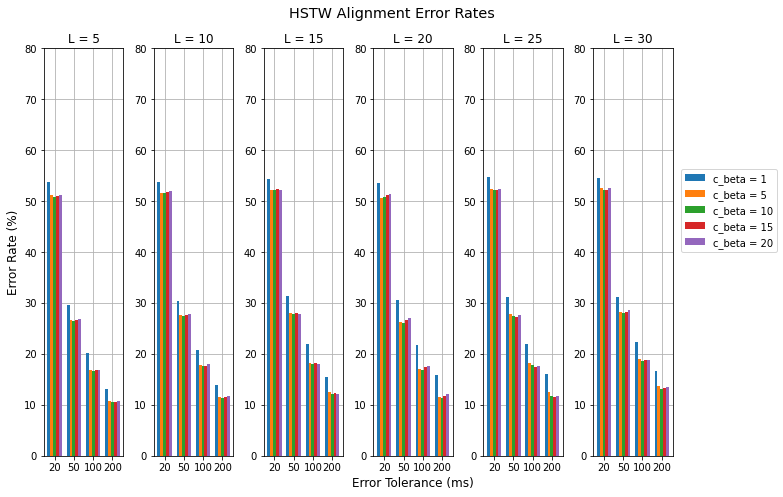

In [49]:
timesToPlot = [5, 10, 15, 20, 25, 30]
betas = [1, 2, 5, 10, 15, 20]
# savefile_names = ['hstw_gamma_20_beta_' + str(beta) + '.pkl' for beta in betas]
# folder_names = ['hstw/gamma_20_beta_' + str(beta) for beta in betas]

# systemsToPlot = ['dtw233', 'dtw111', 'nwtw_gamma_0.8']
# legend = ["DTW,233", "DTW,111", "NWTW,0.8"]
# systemsToPlot = ['nwtw_gamma_0.8', 'nwtw_gamma_1', 'nwtw_gamma_5', 'nwtw_gamma_10', 'nwtw_gamma_20']
# legend = ['0.8', '1', '5', '10', '20']
# systemsToPlot = ['nwtw_gamma_0.8']
# legend = ['NWTW, gamma=0.8']
# systemsToPlot = ['hstw_gamma_1_beta_0', 'hstw_gamma_2_beta_0', 'hstw_gamma_3_beta_0', 'hstw_gamma_4_beta_0', 'hstw_gamma_5_beta_0', 'hstw_gamma_6_beta_0']
systemsToPlot = ['hstw_gamma_20_beta_' + str(beta) for beta in betas]
legend = ["c_beta = " + str(beta) for beta in betas]
cfg = cfg

plotAlignment(timesToPlot, systemsToPlot, legend, cfg, title="HSTW Alignment Error Rates")

hstw_gamma_8_beta_0
/home/cchang/ttmp/partial_match/small/evaluations/alignment/align_clean_to_5s/hstw_gamma_8_beta_0.pkl
hstw_gamma_10_beta_0
/home/cchang/ttmp/partial_match/small/evaluations/alignment/align_clean_to_5s/hstw_gamma_10_beta_0.pkl
hstw_gamma_15_beta_0
/home/cchang/ttmp/partial_match/small/evaluations/alignment/align_clean_to_5s/hstw_gamma_15_beta_0.pkl
hstw_gamma_20_beta_0
/home/cchang/ttmp/partial_match/small/evaluations/alignment/align_clean_to_5s/hstw_gamma_20_beta_0.pkl
hstw_gamma_25_beta_0
/home/cchang/ttmp/partial_match/small/evaluations/alignment/align_clean_to_5s/hstw_gamma_25_beta_0.pkl
hstw_gamma_30_beta_0
/home/cchang/ttmp/partial_match/small/evaluations/alignment/align_clean_to_5s/hstw_gamma_30_beta_0.pkl
hstw_gamma_8_beta_0
/home/cchang/ttmp/partial_match/small/evaluations/alignment/align_clean_to_10s/hstw_gamma_8_beta_0.pkl
hstw_gamma_10_beta_0
/home/cchang/ttmp/partial_match/small/evaluations/alignment/align_clean_to_10s/hstw_gamma_10_beta_0.pkl
hstw_gamma

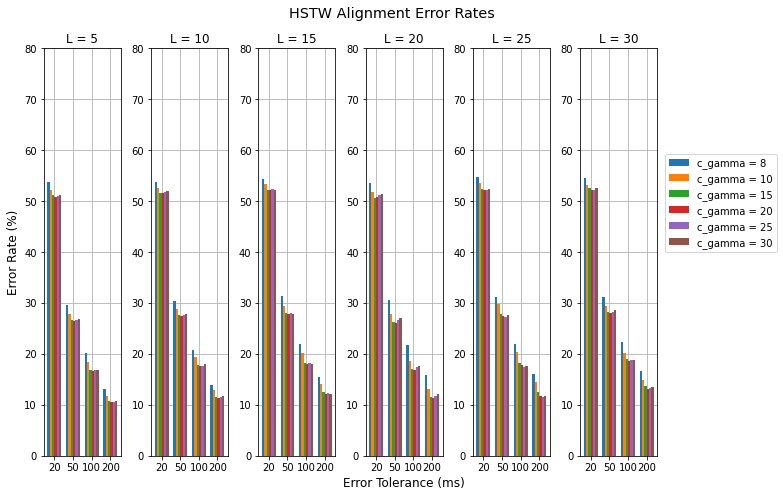

In [34]:
timesToPlot = [5, 10, 15, 20, 25, 30]
# betas = [1, 2, 5, 10, 15, 20]
# savefile_names = ['hstw_gamma_20_beta_' + str(beta) + '.pkl' for beta in betas]
# folder_names = ['hstw/gamma_20_beta_' + str(beta) for beta in betas]

# systemsToPlot = ['dtw233', 'dtw111', 'nwtw_gamma_0.8']
# legend = ["DTW,233", "DTW,111", "NWTW,0.8"]
# systemsToPlot = ['nwtw_gamma_0.8', 'nwtw_gamma_1', 'nwtw_gamma_5', 'nwtw_gamma_10', 'nwtw_gamma_20']
# legend = ['0.8', '1', '5', '10', '20']
# systemsToPlot = ['nwtw_gamma_0.8']
# legend = ['NWTW, gamma=0.8']
# systemsToPlot = ['hstw_gamma_1_beta_0', 'hstw_gamma_2_beta_0', 'hstw_gamma_3_beta_0', 'hstw_gamma_4_beta_0', 'hstw_gamma_5_beta_0', 'hstw_gamma_6_beta_0']
# systemsToPlot = ['hstw_gamma_20_beta_' + str(beta) for beta in betas]
# legend = ["c_beta = " + str(beta) for beta in betas]
cfg = cfg
gammas = [8,10,15,20,25,30]
systemsToPlot = ['hstw_gamma_'+str(gamma)+'_beta_0' for gamma in gammas]
legend = ['c_gamma = ' + str(gamma) for gamma in gammas]
plotAlignment(timesToPlot, systemsToPlot, legend, cfg, title="HSTW Alignment Error Rates")

## Attribution

### Functions

In [16]:
def eval_attribution(hypdir, query_list, hop_sec, annot_file, \
                     savefile = None, scoring_collar = 0.1, sr = 22050):
    '''
    Evaluate the attribution task
    '''
    
    df = pd.read_csv(annot_file)
    allTimestamps = df.set_index('name').to_dict(orient='index')
    attributions = []
    
    # ************************************************************************************************************
    # This section should be easily parallelizable with a starmap
    # Just turn the inputs to evalQuery into a list, 
    #     starmap evalQuery, and store the results in a list called attributions
    with open(query_list, 'r') as f:
        for line in f:
            theseAttributions = evalQuery_attrib(line, allTimestamps, hypdir, hop_sec, annot_file, scoring_collar, sr)
            if len(theseAttributions) > 0:
                attributions.append(theseAttributions)
            #return np.vstack(attributions)
            #return evalQuery_attrib(line, allTimestamps, hypdir, hop_sec, annot_file, scoring_collar, sr)
    # ************************************************************************************************************
    
    attributions = np.vstack(attributions)
    ROC = calc_ROC(attributions)
    #return attributions
    if savefile is not None:
        outdir = os.path.dirname(savefile)
        outdir = Path(outdir)
        outdir.mkdir(parents=True, exist_ok=True)
        pkl.dump(ROC, open(savefile, 'wb'))

    return ROC

In [24]:
def evalQuery_attrib(line, allTimestamps, hypdir, hop_sec, annot_file, scoring_collar, sr):
    scoring_collar_frames = int(scoring_collar / hop_sec)

    parts = line.strip().split()
    assert len(parts) == 2
    basename = os.path.basename(parts[0]) + '__' + os.path.basename(parts[1])
    hypfile = hypdir + '/' + basename + '.pkl'

    if not os.path.exists(hypfile):
        print("X", end='')
        return np.array([])

    hypalign = pkl.load(open(hypfile, 'rb'))
    if hypalign is not None:
        path = hypalign['wp']

        times = allTimestamps[os.path.basename(parts[0]) + ".wav"]

        firstRepEndTime = times['beginning replacement end (idx)'] / sr
        midRepStartTime = times['middle replacement start (idx)'] / sr
        midRepEndTime = times['middle replacement end (idx)'] / sr
        lastRepStartTime = times['ending replacement start (idx)'] / sr
        boundaries = np.array([firstRepEndTime, midRepStartTime, midRepEndTime, lastRepStartTime])

        gt = getAttributionGT(path, boundaries, scoring_collar, hop_sec)
        #return gt
        # Impute cost scores
        # Interpolate here to fill in the frames that the path jumps over
        costs = np.interp(np.arange(path[-1,0]), path[:,0], hypalign["costs"])

        attributions = np.hstack((gt.reshape((-1,1)), costs.reshape((-1,1))))
        
        collarFilter = gt >= 0
        attributions = attributions[collarFilter, :]
        return attributions
    else:
        print("X", end='')
        return np.array([])

In [18]:
def getAttributionGT(path, boundaries, scoring_collar, hop_sec):
    query_length = path[-1,0]
    boundaryFrames = np.round(boundaries / hop_sec).astype(int)
    # Assemble gt with no scoring collar
    gt = np.zeros(query_length) + 1
    gt[boundaryFrames[0]:boundaryFrames[1]] = 0
    gt[boundaryFrames[2]:boundaryFrames[3]] = 0
    
    # Apply scoring collar:
    for boundary in boundaries:
        collarStartTime = boundary - scoring_collar
        collarStartFrame = int(np.ceil(collarStartTime / hop_sec))
        collarEndTime = boundary + scoring_collar
        collarEndFrame = int(np.ceil(collarEndTime / hop_sec))
        gt[collarStartFrame:collarEndFrame] = -1
    
    return gt

In [19]:
def calc_ROC(attributions):
    fps, tps, thresholds = metrics.roc_curve(attributions[:,0], attributions[:,1])
    return np.array([thresholds, fps, 1-tps]).T

In [88]:
# fname = "Chopin_Op030No2_Ashkenazy-1981_pid9058-19__Chopin_Op030No2_Ashkenazy-1982_pid50848-03.pkl"
# with open('/home/cchang/ttmp/partial_match/small/experiments/align_clean_to_5s/hstw/gamma_20_beta_10/' + fname, 'rb') as f:
#     contents = pkl.load(f)
#     print(contents)

### Evaluate Attribution

In [25]:
ROCCurves = []
for t in times:
    EXPERIMENTS_ROOT = '/home/cchang/ttmp/partial_match/%s/experiments/align_clean_to_%ss' % (cfg, t)
    EVALUATIONS_ROOT = '/home/cchang/ttmp/partial_match/%s/evaluations/attribution/align_clean_to_%ss' % (cfg, t)

    ts = '/home/cchang/ttmp/raw_data/partial_match/Chopin_Mazurkas_partial_match_%ss/replacement_ts.csv' % t
    for i in range(len(savefile_names)):
        savefile = EVALUATIONS_ROOT + "/" + savefile_names[i]
        hypdir = EXPERIMENTS_ROOT + "/" + folder_names[i]
        print(hypdir)

        start = time.time()
        ROC = eval_attribution(hypdir, query_list, hop_sec, ts, savefile = savefile, scoring_collar = 0.1)
        ROCCurves.append(ROC)
        print('Took ', time.time() - start)

/home/cchang/ttmp/partial_match/small/experiments/align_clean_to_5s/hstw/gamma_20_beta_10
Took  0.13994407653808594
/home/cchang/ttmp/partial_match/small/experiments/align_clean_to_10s/hstw/gamma_20_beta_10
Took  0.11058688163757324
/home/cchang/ttmp/partial_match/small/experiments/align_clean_to_15s/hstw/gamma_20_beta_10
Took  0.11506533622741699
/home/cchang/ttmp/partial_match/small/experiments/align_clean_to_20s/hstw/gamma_20_beta_10
Took  0.1132957935333252
/home/cchang/ttmp/partial_match/small/experiments/align_clean_to_25s/hstw/gamma_20_beta_10
Took  0.11502742767333984
/home/cchang/ttmp/partial_match/small/experiments/align_clean_to_30s/hstw/gamma_20_beta_10
Took  0.11508345603942871


### Figures

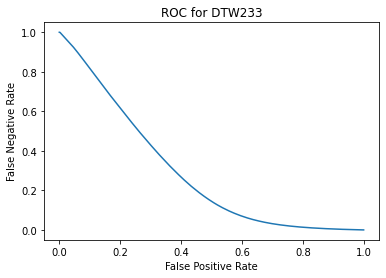

In [14]:
ROC = ROCCurves[0]
plt.plot(ROC[:,1], ROC[:,2])
plt.xlabel("False Positive Rate");
plt.ylabel("False Negative Rate");
plt.title("ROC for DTW233");

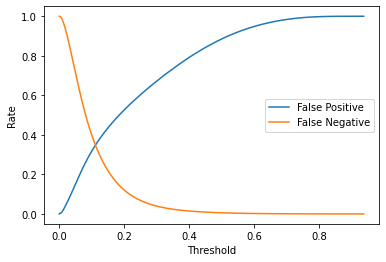

In [15]:
# Mine (training)
plt.plot(ROC[:,0], ROC[:,1]);
plt.plot(ROC[:,0], ROC[:,2]);
plt.xlabel("Threshold");
plt.ylabel("Rate")
plt.legend(["False Positive", "False Negative"]);

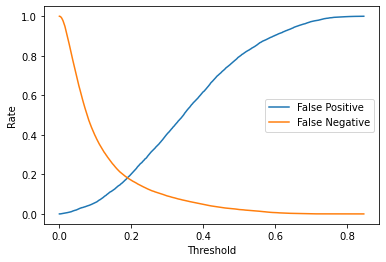

In [23]:
# Small dataset
plt.plot(ROC[:,0], ROC[:,1]);
plt.plot(ROC[:,0], ROC[:,2]);
plt.xlabel("Threshold");
plt.ylabel("Rate")
plt.legend(["False Positive", "False Negative"]);

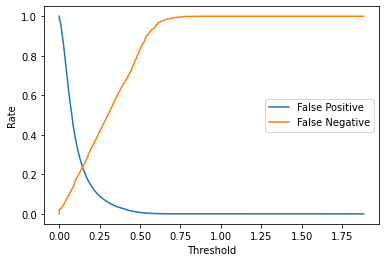

In [26]:
# Small dataset, for HSTW
plt.plot(ROC[:,0], ROC[:,1]);
plt.plot(ROC[:,0], ROC[:,2]);
plt.xlabel("Threshold");
plt.ylabel("Rate")
plt.legend(["False Positive", "False Negative"]);

In [93]:
def plotAttribution(timesToPlot, systemsToPlot, legend, cfg):
    EERs = np.zeros((len(timesToPlot), len(systemsToPlot)))
    for i, plotTime in enumerate(timesToPlot):
        for j, plotSys in enumerate(systemsToPlot):
            ROCfile = '/home/cchang/ttmp/partial_match/%s/evaluations/attribution/align_clean_to_%ss/%s.pkl' \
            % (cfg, str(plotTime), plotSys)
            ROC = pkl.load(open(ROCfile, 'rb'))
            FP, FN, minDiff = findEER(ROC)
            EERs[i,j] = (FP + FN) / 2 # Take the average of the FP and FN rates when they are at the closest point
            
    x = np.arange(len(timesToPlot))
    numBars = len(systemsToPlot)
    width = 0.75 / numBars
    
    for i in range(numBars):
        plt.bar(x - width * (numBars / 2) + (i + 1/2) * width, EERs[:,i] * 100, width)
    
    plt.ylim(0,100)
    plt.ylabel("Equal Error Rate (%)")
    
    plt.xlabel("Edit Duration (s)")
    plt.xticks(x, timesToPlot)
    
    plt.legend(legend)
    plt.title("EER For Different Systems at With Different Edit Lengths")

In [94]:
def findEER(ROC):
    '''
    Calculates Equal Error Rate based on ROC
    
    '''
    minDiff = np.inf
    savedFP = 0
    savedFN = 0

    for rate in ROC:
        FP = rate[1]
        FN = rate[2]

        if np.abs(FP - FN) < minDiff:
            minDiff = np.abs(FP - FN)
            savedFP = FP
            savedFN = FN
            
    return savedFP, savedFN, minDiff

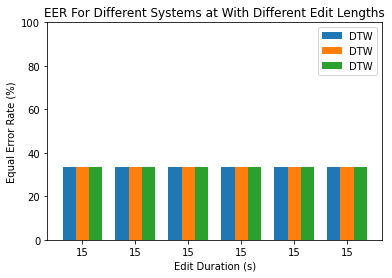

In [95]:
timesToPlot = [15, 15, 15, 15, 15, 15]
systemsToPlot = ['dtw233', 'dtw233', 'dtw233']
legend = ["DTW", "DTW", "DTW"]

cfg = cfg # Change this at top of file to change which benchmark is being plot

plotAttribution(timesToPlot, systemsToPlot, legend, cfg)

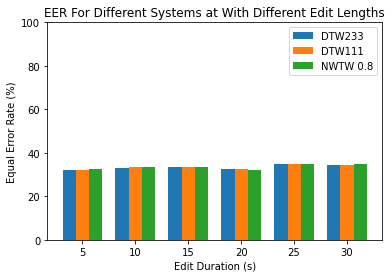

In [96]:
timesToPlot = [5, 10, 15, 20, 25, 30]
systemsToPlot = ['dtw233', 'dtw111', 'nwtw_gamma_0.8']
legend = ["DTW233", "DTW111", "NWTW 0.8"]

cfg = cfg # Change this at top of file to change which benchmark is being plot

plotAttribution(timesToPlot, systemsToPlot, legend, cfg)